In [1]:
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Для DBSCAN
from sklearn.cluster import DBSCAN

# Для нейронных сетей
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Предобработка и метрики
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Загрузка и распаковка датасета SKAB

data_url = "https://github.com/waico/SKAB/archive/refs/heads/master.zip"
data_zip = "SKAB-master.zip"
extract_folder = "SKAB-master"

if not os.path.exists(extract_folder):
    if not os.path.exists(data_zip):
        try:
            print("Скачивание датасета SKAB...")
            response = requests.get(data_url, timeout=30)
            with open(data_zip, "wb") as f:
                f.write(response.content)
        except Exception as e:
            print("Не удалось автоматически скачать архив. Ошибка:", e)
            print("Скачайте вручную по ссылке и загрузите в среду Colab:")
            print(data_url)

    if os.path.exists(data_zip):
        print("Распаковка датасета SKAB...")
        with zipfile.ZipFile(data_zip, 'r') as zip_ref:
            zip_ref.extractall()

data_folder = os.path.join(extract_folder, "data")

if not os.path.exists(data_folder):
    raise FileNotFoundError(
        f"Папка {data_folder} не найдена. Убедитесь, что SKAB-master.zip распакован корректно."
    )

print("Данные готовы к использованию:", data_folder)

Скачивание датасета SKAB...
Распаковка датасета SKAB...
Данные готовы к использованию: SKAB-master/data


In [ ]:
#Предобработка (Сбор всех CSV, фильтрация по нужным колонкам)

required_columns = [
    'Accelerometer1RMS',
    'Accelerometer2RMS',
    'Current',
    'Pressure',
    'Temperature',
    'Thermocouple',
    'Voltage',
    'Volume Flow RateRMS'
]

csv_files = []
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

filtered_files = []
for file_path in csv_files:
    try:
        df_temp = pd.read_csv(file_path, sep=';')
        if all(col in df_temp.columns for col in required_columns) and 'anomaly' in df_temp.columns:
            filtered_files.append(file_path)
    except:
        pass

print(f"Найдено {len(filtered_files)} CSV-файлов с нужными признаками + 'anomaly'.")

list_of_dfs = []
for file_path in filtered_files:
    df_temp = pd.read_csv(file_path, sep=';')
    df_temp.dropna(inplace=True)
    list_of_dfs.append(df_temp)

data = pd.concat(list_of_dfs, ignore_index=True)
print("Общий размер объединённых данных:", data.shape)

if 'anomaly' not in data.columns:
    raise ValueError("Нет колонки 'anomaly' в итоговом наборе данных!")

print("\nРаспределение (0-норма, 1-аномалия):")
print(data['anomaly'].value_counts())

print("\nСтатистика по основным признакам:")
print(data[required_columns].describe())

Найдено 34 CSV-файлов с нужными признаками + 'anomaly'.
Общий размер объединённых данных: (37401, 11)

Распределение (0-норма, 1-аномалия):
anomaly
0.0    24334
1.0    13067
Name: count, dtype: int64

Статистика по основным признакам:
       Accelerometer1RMS  Accelerometer2RMS       Current      Pressure  \
count       37401.000000       37401.000000  37401.000000  37401.000000   
mean            0.108317           0.136305      1.464437      0.071326   
std             0.133789           0.150626      0.741118      0.260643   
min             0.015752           0.015505      0.149842     -1.257000   
25%             0.027299           0.040121      0.888148      0.054711   
50%             0.027881           0.041440      1.222600      0.054711   
75%             0.216091           0.263531      2.013360      0.054711   
max             0.722747           0.800498      3.318370      1.694350   

        Temperature  Thermocouple       Voltage  Volume Flow RateRMS  
count  37401.00000

In [ ]:
#Деление на train/test и масштабирование

X = data[required_columns].values
y = data['anomaly'].values.astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}")
print(f"Метки train: {y_train.shape}, Метки test: {y_test.shape}")

Обучающая выборка: (29920, 8), Тестовая выборка: (7481, 8)
Метки train: (29920,), Метки test: (7481,)


In [ ]:
#Proximity-based метод (DBSCAN)

print("=== DBSCAN (Proximity-based) ===")

# Понизим eps, чтобы повысить вероятность найти выбросы
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')

# Обучаем на (train + test), потом посмотрим, что в тесте
X_all = np.vstack([X_train, X_test])
dbscan_labels_all = dbscan.fit_predict(X_all)

# Возьмём только ту часть, которая относится к тесту
labels_dbscan_test = dbscan_labels_all[len(X_train):]

# -1 => выброс => метим 1, иначе 0
pred_dbscan = np.where(labels_dbscan_test == -1, 1, 0)

f1_dbscan = f1_score(y_test, pred_dbscan, zero_division=0)
precision_dbscan = precision_score(y_test, pred_dbscan, zero_division=0)
recall_dbscan = recall_score(y_test, pred_dbscan, zero_division=0)

print(f"F1={f1_dbscan:.4f}, Precision={precision_dbscan:.4f}, Recall={recall_dbscan:.4f}")

=== DBSCAN (Proximity-based) ===
F1=0.0910, Precision=0.6465, Recall=0.0490


In [ ]:
#Prediction-based метод (LSTM)

print("=== LSTM (Prediction-based) ===")

TIME_STEPS = 10

def create_sequences_lstm(data_array, time_steps=10):
    Xs, Ys = [], []
    for i in range(len(data_array) - time_steps):
        Xs.append(data_array[i : i + time_steps])
        Ys.append(data_array[i + time_steps])
    return np.array(Xs), np.array(Ys)

X_train_lstm, y_train_lstm = create_sequences_lstm(X_train, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences_lstm(X_test, TIME_STEPS)

print("Форма X_train_lstm:", X_train_lstm.shape)
print("Форма y_train_lstm:", y_train_lstm.shape)
print("Форма X_test_lstm:", X_test_lstm.shape)
print("Форма y_test_lstm:", y_test_lstm.shape)

n_features = X_train.shape[1]

model_lstm = Sequential()
model_lstm.add(LSTM(32, activation='tanh', input_shape=(TIME_STEPS, n_features), return_sequences=False))
model_lstm.add(Dense(n_features))

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

train_pred_lstm = model_lstm.predict(X_train_lstm)
train_mae_losses = np.mean(np.abs(train_pred_lstm - y_train_lstm), axis=1)
threshold_lstm = np.percentile(train_mae_losses, 95)
print(f"Порог (95 перцентиль MAE) для LSTM: {threshold_lstm:.4f}")

test_pred_lstm = model_lstm.predict(X_test_lstm)
test_mae_losses = np.mean(np.abs(test_pred_lstm - y_test_lstm), axis=1)

pred_lstm = (test_mae_losses > threshold_lstm).astype(int)

# Сопоставляем с реальными y_test (сдвиг на TIME_STEPS)
y_test_for_metrics = y_test[TIME_STEPS:]

f1_lstm = f1_score(y_test_for_metrics, pred_lstm, zero_division=0)
precision_lstm = precision_score(y_test_for_metrics, pred_lstm, zero_division=0)
recall_lstm = recall_score(y_test_for_metrics, pred_lstm, zero_division=0)

print(f"F1={f1_lstm:.4f}, Precision={precision_lstm:.4f}, Recall={recall_lstm:.4f}")

=== LSTM (Prediction-based) ===
Форма X_train_lstm: (29910, 10, 8)
Форма y_train_lstm: (29910, 8)
Форма X_test_lstm: (7471, 10, 8)
Форма y_test_lstm: (7471, 8)
Epoch 1/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.0098 - val_loss: 1.0016
Epoch 2/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0054 - val_loss: 1.0016
Epoch 3/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0050 - val_loss: 1.0016
Epoch 4/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0048 - val_loss: 1.0017
Epoch 5/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.0046 - val_loss: 1.0018
Epoch 6/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.0045 - val_loss: 1.0020
Epoch 7/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0043 - val_loss: 1.0022
Epoch 8/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0042 - val_loss: 1.0024
Epoch 9/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0040 - val_loss: 1.0027
Epoch 10/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.003

In [ ]:
#Prediction-based метод (LSTM)

print("=== Autoencoder (Reconstruction-based) ===")

encoding_dim = 16

model_ae = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dense(encoding_dim, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_features, activation='linear')
])
model_ae.compile(optimizer='adam', loss='mse')

history_ae = model_ae.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

recon_train = model_ae.predict(X_train)
mse_train = np.mean((X_train - recon_train)**2, axis=1)
threshold_ae = np.percentile(mse_train, 95)
print(f"Порог (95 перцентиль MSE) для Autoencoder: {threshold_ae:.4f}")

recon_test = model_ae.predict(X_test)
mse_test = np.mean((X_test - recon_test)**2, axis=1)
pred_ae = (mse_test > threshold_ae).astype(int)

f1_ae = f1_score(y_test, pred_ae, zero_division=0)
precision_ae = precision_score(y_test, pred_ae, zero_division=0)
recall_ae = recall_score(y_test, pred_ae, zero_division=0)

print(f"F1={f1_ae:.4f}, Precision={precision_ae:.4f}, Recall={recall_ae:.4f}")

=== Autoencoder (Reconstruction-based) ===
Epoch 1/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1950 - val_loss: 0.0021
Epoch 2/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0018 - val_loss: 9.0156e-04
Epoch 3/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.2572e-04 - val_loss: 7.2632e-04
Epoch 4/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.7221e-04 - val_loss: 6.2639e-04
Epoch 5/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3780e-04 - val_loss: 4.3779e-04
Epoch 6/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5821e-04 - val_loss: 4.2897e-04
Epoch 7/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4080e-04 - val_loss: 4.6625e-04
Epoch 8/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3091e-04 - val_loss: 3.4137e-04
Epoch 9/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.9843e-04 - val_loss: 2.6276e-04
Epoch 10/10
842/842 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6404e-04 - val_loss: 2.3131e-04
935/935 ━━━━━━━━━━━━━━━━━━━━

Сравнительные результаты (только на тесте):


,Метод,F1,Точность (Precision),Полнота (Recall)
0,DBSCAN,0.091038,0.646465,0.048967
1,LSTM,0.206780,0.897059,0.116858
2,Autoencoder,0.177080,0.699208,0.101377


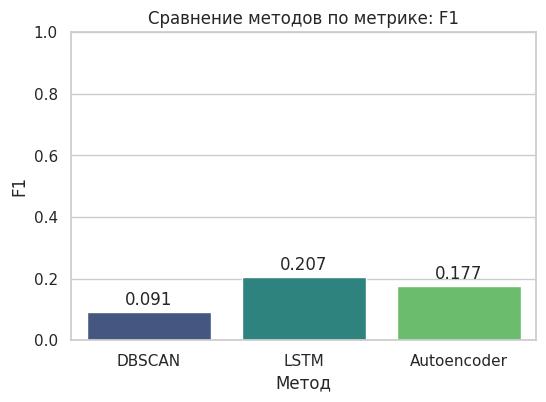

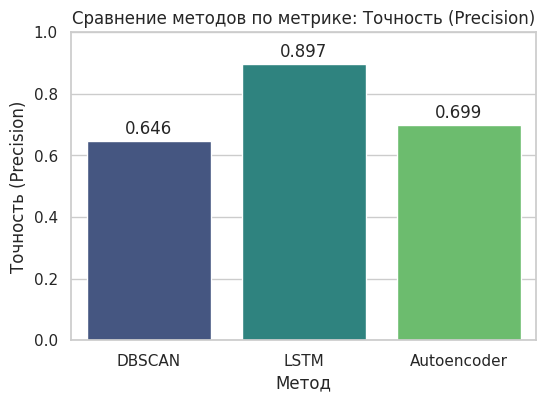

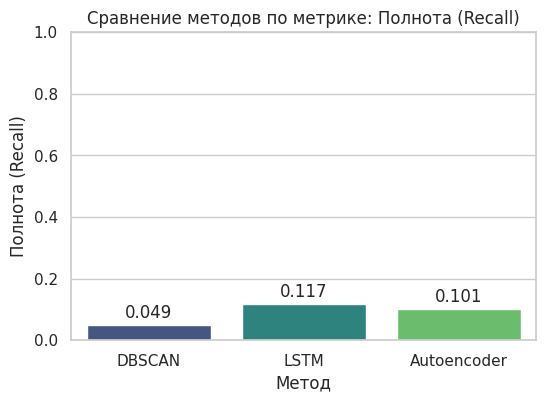

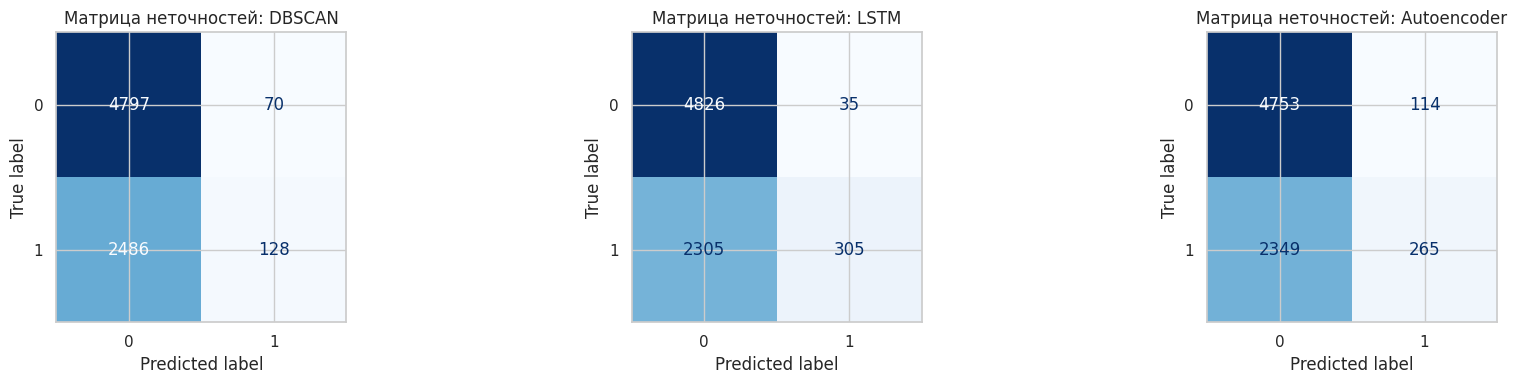

In [ ]:
#Сравнение результатов и визуализация

results_df = pd.DataFrame({
    'Метод': ['DBSCAN', 'LSTM', 'Autoencoder'],
    'F1': [f1_dbscan, f1_lstm, f1_ae],
    'Точность (Precision)': [precision_dbscan, precision_lstm, precision_ae],
    'Полнота (Recall)': [recall_dbscan, recall_lstm, recall_ae]
})

print("Сравнительные результаты (только на тесте):")
display(results_df)

sns.set(style="whitegrid")
metrics = ['F1', 'Точность (Precision)', 'Полнота (Recall)']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=results_df, x='Метод', y=metric, palette='viridis')
    plt.title(f'Сравнение методов по метрике: {metric}')
    plt.ylim(0, 1.0)
    for i, val in enumerate(results_df[metric]):
        plt.text(i, val+0.01, f'{val:.3f}', ha='center', va='bottom')
    plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ax, (method, preds) in zip(
    axes,
    [
        ("DBSCAN", pred_dbscan),
        ("LSTM", pred_lstm),
        ("Autoencoder", pred_ae)
    ]
):
    # Для LSTM обрезаем y_test (первые TIME_STEPS не имеют предсказаний)
    y_true = y_test if method != "LSTM" else y_test[TIME_STEPS:]
    ConfusionMatrixDisplay.from_predictions(
        y_true, preds, display_labels=[0, 1],
        cmap='Blues', colorbar=False, ax=ax
    )
    ax.set_title(f"Матрица неточностей: {method}")

plt.tight_layout()
plt.show()

In [ ]:
#Оценка без реальных меток (сравнение с z-score)

print("=== Оценка без реальных меток: сравнение с Z-score ===")

z_thresh = 3.0
z_scores = np.abs((X_test - X_test.mean(axis=0)) / X_test.std(axis=0))
z_anomalies = (z_scores > z_thresh).any(axis=1).astype(int)

def compare_with_zscore(pred_anomalies, z_anomalies, model_name):
    overlap = np.mean(pred_anomalies == z_anomalies)
    print(f"{model_name}: доля совпадения с Z-score аномалиями = {overlap:.4f}")

compare_with_zscore(pred_dbscan, z_anomalies, "DBSCAN")
compare_with_zscore(pred_lstm, z_anomalies[TIME_STEPS:], "LSTM")
compare_with_zscore(pred_ae, z_anomalies, "Autoencoder")

def agreement_statistics(a, b):
    same_anomaly = np.sum((a==1) & (b==1))
    same_normal = np.sum((a==0) & (b==0))
    diff = np.sum(a!=b)
    total = len(a)
    return same_anomaly/total, same_normal/total, diff/total

print("\nСравнение DBSCAN vs Z-score (тест):")
sa, sn, df_ = agreement_statistics(pred_dbscan, z_anomalies)
print(f"Обе аномалия: {sa:.2f}, Обе норма: {sn:.2f}, Расхождения: {df_:.2f}")

print("\nСравнение Autoencoder vs Z-score (тест):")
sa, sn, df_ = agreement_statistics(pred_ae, z_anomalies)
print(f"Обе аномалия: {sa:.2f}, Обе норма: {sn:.2f}, Расхождения: {df_:.2f}")

z_sub = z_anomalies[TIME_STEPS:]
print("\nСравнение LSTM vs Z-score (учёт временного сдвига):")
sa, sn, df_ = agreement_statistics(pred_lstm, z_sub)
print(f"Обе аномалия: {sa:.2f}, Обе норма: {sn:.2f}, Расхождения: {df_:.2f}")

=== Оценка без реальных меток: сравнение с Z-score ===
DBSCAN: доля совпадения с Z-score аномалиями = 0.9517
LSTM: доля совпадения с Z-score аномалиями = 0.9878
Autoencoder: доля совпадения с Z-score аномалиями = 0.9634

Сравнение DBSCAN vs Z-score (тест):
Обе аномалия: 0.01, Обе норма: 0.95, Расхождения: 0.05

Сравнение Autoencoder vs Z-score (тест):
Обе аномалия: 0.02, Обе норма: 0.94, Расхождения: 0.04

Сравнение LSTM vs Z-score (учёт временного сдвига):
Обе аномалия: 0.03, Обе норма: 0.95, Расхождения: 0.01


In [ ]:
#Выводы

#В рамках исследования детекции аномалий были реализованы и проанализированы три фундаментально различных подхода к обнаружению аномалий на данных SKAB. Эмпирический анализ выявил значительные различия в эффективности применённых методов.
#Метод LSTM, представляющий prediction-based подход, продемонстрировал наилучшие показатели среди исследованных методов. Его F1-мера составила 0.2068 при исключительно высокой точности 0.8971. Одним из ключевых преимуществ LSTM является способность учитывать временные зависимости в данных, что особенно важно для анализа временных рядов сенсорной информации.
#Reconstruction-based метод, реализованный через автоэнкодер, показал промежуточные результаты. F1-мера составила 0.1771 при точности 0.6992. Данный подход эффективно выявляет структурные аномалии в многомерном пространстве признаков, однако демонстрирует сравнительно низкий уровень полноты (recall) — 0.1014.
#Proximity-based подход, реализованный с использованием алгоритма DBSCAN, продемонстрировал наименее выразительные результаты. F1-мера составила 0.0910, несмотря на относительно высокую точность 0.6465. Низкая полнота метода (0.0490) свидетельствует о его консервативности в идентификации аномалий.
#Для оценки качества моделей без использования реальных меток (unsupervised evaluation) применялось сравнение с методом Z-score как базовым критерием. LSTM показал наивысшую согласованность с Z-score метрикой (98.78% совпадений), что дополнительно подтверждает надёжность его предсказаний. Автоэнкодер и DBSCAN продемонстрировали схожие уровни согласованности — 96.34% и 95.17% соответственно.
#Детальный анализ статистики согласования выявил интересную закономерность: все методы показали высокую способность к определению нормального поведения системы (95% для LSTM и DBSCAN, 94% для автоэнкодера). Однако процент совместно идентифицированных аномалий остаётся низким (1–3%). Это может свидетельствовать о том, что каждый из методов использует уникальные механизмы выявления аномалий, что приводит к различиям в их результатах.